In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import random
import rasterio
import numpy as np
import classic_algos.bicubic_interpolation as bicubic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )

cuda


In [10]:
class SatelliteSRDataset(Dataset):
    def __init__(self, root_dir, scale_factor=3, hr_patch_size=144, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.hr_patch_size = hr_patch_size
        self.augment = augment

        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()  # C x H x W

        image_norm = image.astype(np.float32) / 255.0

        #random crop
        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top+self.hr_patch_size, left:left+self.hr_patch_size]
        if self.augment:
            # Flip Horizontal
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=2)

            # Flip Vertical
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=1)

            # rotations
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np.astype(np.float32))  # C x H x W, [0,1]
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        # LR from augmented HR patch
        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))  # H x W x C, [0,1]
        lr_size = self.hr_patch_size // self.scale_factor
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)
        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))  # C x h_lr x w_lr
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor

In [11]:
class FSRCNN(nn.Module):
    def __init__(self):
        """
        d: filters dimension
        s: shrinking dimension
        m: mapping layers number
        """
        d, s, m = 56, 12, 4
        scale_factor = 3
        channels = 3
        super(FSRCNN, self).__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(channels, d, kernel_size=5, padding=2),
            nn.PReLU(d)
        )

        self.shrink = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU(s)
        )

        map_layers = []
        for _ in range(m):
            map_layers.extend([nn.Conv2d(s, s, kernel_size=3, padding=1),
                               nn.PReLU(s)
            ])
        self.mapping = nn.Sequential(*map_layers)

        self.expand = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU(d)
        )

        self.deconv = nn.ConvTranspose2d(d, channels,
                                         kernel_size=9,
                                         stride=3,
                                         padding=3,
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrink(x)
        x = self.mapping(x)
        x = self.expand(x)
        x = self.deconv(x)
        x = torch.clamp(x, 0.0, 1.0)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=0.001)
                if m.bias is not None:
                    nn.init.zeros_(m.bias.data)


train

In [12]:
def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / (mse + 1e-20))

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from pathlib import Path
BATCH_SIZE = 128
EPOCHS = 200

TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'fsrcnn_models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


In [14]:
train_dataset = SatelliteSRDataset(TRAIN_DIR)
val_dataset = SatelliteSRDataset(VAL_DIR, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
model = FSRCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


In [17]:
loss = []
psnr_metric = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        optimizer.zero_grad()
        sr_imgs = model(lr_imgs)
        batch_loss = criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss.append(avg_loss)
    scheduler.step()

    if epoch % 5 != 0:
        continue

    model.eval()
    epoch_psnr = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            epoch_psnr += PSNR(sr_imgs, hr_imgs).item()
    avg_psnr = epoch_psnr / len(val_loader)
    psnr_metric.append(avg_psnr)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB")
    torch.save(model.state_dict(), MODEL_DIR / f'fsrcnn_epoch_{epoch}.pth')

print("Training complete.")

100%|██████████| 14/14 [00:05<00:00,  2.38it/s]


Epoch 0, Loss: 0.4804, PSNR: 5.76 dB


100%|██████████| 14/14 [00:03<00:00,  4.02it/s]


Epoch 5, Loss: 0.4249, PSNR: 6.98 dB


100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


Epoch 10, Loss: 0.1304, PSNR: 15.46 dB


100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


Epoch 15, Loss: 0.1234, PSNR: 15.77 dB


100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


Epoch 20, Loss: 0.1187, PSNR: 15.91 dB


100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


Epoch 25, Loss: 0.1149, PSNR: 16.10 dB


100%|██████████| 14/14 [00:03<00:00,  4.01it/s]


Epoch 30, Loss: 0.1119, PSNR: 16.10 dB


100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


Epoch 35, Loss: 0.1092, PSNR: 16.22 dB


100%|██████████| 14/14 [00:03<00:00,  4.02it/s]


Epoch 40, Loss: 0.1088, PSNR: 16.37 dB


100%|██████████| 14/14 [00:03<00:00,  3.98it/s]


Epoch 45, Loss: 0.1058, PSNR: 16.44 dB


100%|██████████| 14/14 [00:03<00:00,  3.99it/s]


Epoch 50, Loss: 0.1022, PSNR: 16.64 dB


100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


Epoch 55, Loss: 0.1007, PSNR: 16.80 dB


100%|██████████| 14/14 [00:03<00:00,  4.22it/s]


Epoch 60, Loss: 0.0988, PSNR: 17.04 dB


100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


Epoch 65, Loss: 0.0943, PSNR: 17.38 dB


100%|██████████| 14/14 [00:03<00:00,  4.00it/s]


Epoch 70, Loss: 0.0886, PSNR: 17.86 dB


100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


Epoch 75, Loss: 0.0841, PSNR: 18.39 dB


100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


Epoch 80, Loss: 0.0817, PSNR: 18.58 dB


100%|██████████| 14/14 [00:03<00:00,  4.01it/s]


Epoch 85, Loss: 0.0825, PSNR: 18.74 dB


100%|██████████| 14/14 [00:03<00:00,  3.91it/s]


Epoch 90, Loss: 0.0815, PSNR: 18.73 dB


100%|██████████| 14/14 [00:03<00:00,  4.03it/s]


Epoch 95, Loss: 0.0819, PSNR: 18.79 dB


100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


Epoch 100, Loss: 0.0817, PSNR: 18.76 dB


100%|██████████| 14/14 [00:03<00:00,  3.96it/s]


Epoch 105, Loss: 0.0804, PSNR: 18.76 dB


100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


Epoch 110, Loss: 0.0806, PSNR: 18.79 dB


100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


Epoch 115, Loss: 0.0800, PSNR: 18.86 dB


100%|██████████| 14/14 [00:03<00:00,  3.93it/s]


Epoch 120, Loss: 0.0797, PSNR: 18.84 dB


100%|██████████| 14/14 [00:03<00:00,  3.85it/s]


Epoch 125, Loss: 0.0798, PSNR: 18.88 dB


100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


Epoch 130, Loss: 0.0796, PSNR: 18.87 dB


100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


Epoch 135, Loss: 0.0792, PSNR: 18.94 dB


100%|██████████| 14/14 [00:03<00:00,  4.21it/s]


Epoch 140, Loss: 0.0787, PSNR: 18.95 dB


100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


Epoch 145, Loss: 0.0790, PSNR: 18.94 dB


100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


Epoch 150, Loss: 0.0788, PSNR: 19.00 dB


100%|██████████| 14/14 [00:03<00:00,  4.01it/s]


Epoch 155, Loss: 0.0791, PSNR: 19.05 dB


100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


Epoch 160, Loss: 0.0782, PSNR: 19.05 dB


100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


Epoch 165, Loss: 0.0790, PSNR: 19.01 dB


100%|██████████| 14/14 [00:03<00:00,  4.05it/s]


Epoch 170, Loss: 0.0780, PSNR: 18.99 dB


100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


Epoch 175, Loss: 0.0786, PSNR: 19.11 dB


100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


Epoch 180, Loss: 0.0785, PSNR: 19.02 dB


100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


Epoch 185, Loss: 0.0782, PSNR: 19.09 dB


100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


Epoch 190, Loss: 0.0776, PSNR: 19.13 dB


100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


Epoch 195, Loss: 0.0780, PSNR: 19.10 dB


100%|██████████| 14/14 [00:03<00:00,  4.12it/s]

Training complete.


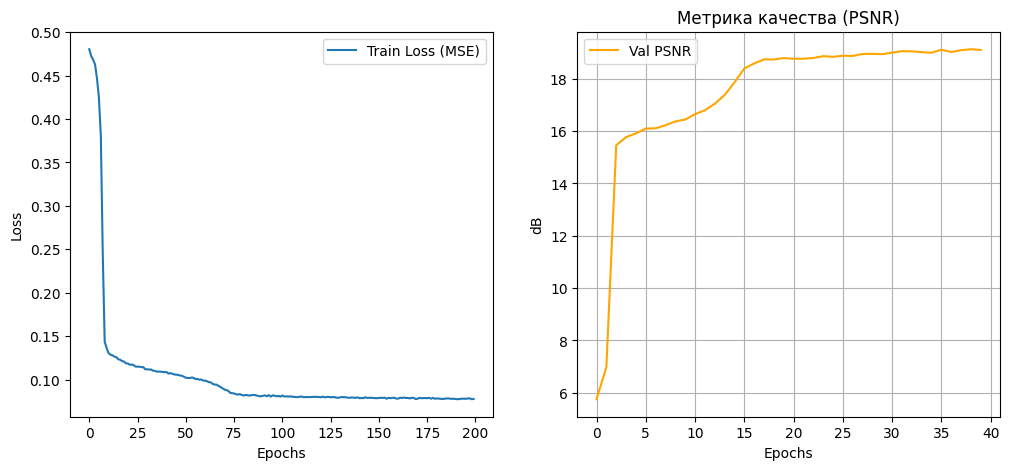

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(psnr_metric, label='Val PSNR', color='orange')
plt.title('Метрика качества (PSNR)')
plt.xlabel('Epochs')
plt.ylabel('dB')
plt.legend()
plt.grid(True)

plt.show()

In [18]:
# Baseline: Bicubic PSNR
print("Calculating baseline PSNR for bicubic interpolation...")
bicubic_psnr_total = 0
with torch.no_grad():
    for lr_imgs, hr_imgs in tqdm(val_loader, desc="Bicubic Validation"):
        # Перемещаем на CPU для обработки с NumPy
        lr_imgs_cpu = lr_imgs.cpu()
        hr_imgs_cpu = hr_imgs.cpu()

        sr_bicubic_batch = []
        for i in range(lr_imgs_cpu.shape[0]):
            lr_np = lr_imgs_cpu[i].numpy()
            lr_np_hwc = np.transpose(lr_np, (1, 2, 0))

            hr_h, hr_w = hr_imgs_cpu.shape[2], hr_imgs_cpu.shape[3]

            sr_bicubic_np_hwc = bicubic.SR_bicubic(
                lr_np_hwc, hr_h, hr_w,
                output_dtype=np.float32, preserve_range=True
            )

            sr_bicubic_np = np.transpose(sr_bicubic_np_hwc, (2, 0, 1))
            sr_bicubic_batch.append(torch.from_numpy(sr_bicubic_np))

        sr_bicubic_tensor = torch.stack(sr_bicubic_batch).to(device)
        hr_imgs = hr_imgs.to(device)

        bicubic_psnr_total += PSNR(sr_bicubic_tensor, hr_imgs).item()

avg_bicubic_psnr = bicubic_psnr_total / len(val_loader)
print(f"Average Bicubic PSNR on validation set: {avg_bicubic_psnr:.2f} dB")
